In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.multioutput import MultiOutputClassifier
from scipy.stats import chi2_contingency


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import numpy as np
import ast


In [2]:
df = pd.read_excel('../data/processed/Footballers_questionnaire.xlsx')

# Check the columns of the dataset

print(df.head())

    ID                                          Questions        Option  Rank  \
0  101                                        A1. Gender?        Female     0   
1  101                              A5. Are you employed?           Yes     1   
2  101  A6. Is your job related to football? (Please c...           Yes     1   
3  101  A7. Indicate your highest level of education. ...        Master     0   
4  101              A8. Type of institution you work for.  Governmental     0   

  Question-Group Main_Topic            Sub_Topic  
0              A      Peace              General  
1              A      Women  Women's Empowerment  
2              A      Women     Women's Football  
3              A  Education              General  
4              A      Women  Women's Empowerment  


## Step 1: Prepare the data
 - First, we will prepare the data for analysis.
 - The text columns will be converted to numeric data.

In [3]:
# Let's assume that df is your dataframe and column_name is the name of the column being encoded.
def show_encode_values(df, column_name):
    encoder = LabelEncoder()
    
    # Apply encoding
    df[column_name] = encoder.fit_transform(df[column_name])
    
   # Create a new dataframe that displays unique values and their encoded equivalents
    mapping_df = pd.DataFrame({
        'Unique Value': encoder.classes_,
        'Encoded Value': range(len(encoder.classes_))
    })
    

    return  mapping_df


In [4]:
mapping_Main_Topic = show_encode_values(df ,'Main_Topic')
mapping_Main_Topic

,Unique Value,Encoded Value
0,Challenges,0
1,Education,1
2,Peace,2
3,Tourism,3
4,Women,4


In [5]:
mapping_Sub_Topic = show_encode_values(df ,'Sub_Topic')
mapping_Sub_Topic.to_excel('../results/Footballers/mapping_Sub_Topic.xlsx')
mapping_Sub_Topic

,Unique Value,Encoded Value
0,Cultural Challenges,0
1,Cultural Exchange,1
2,Cultural and Social Challenges,2
3,Destination Management,3
4,Development of Sports and Tourism Infrastructure,4
5,Education,5
6,Gender Discrimination,6
7,Gender Equality,7
8,General,8
9,Improving Attitudes,9


In [6]:
mapping_Option = show_encode_values(df ,'Option')
mapping_Option.to_excel('../results/Footballers/mapping-option.xlsx')
mapping_Option

,Unique Value,Encoded Value
0,0,0
1,4,1
2,Addressing cultural and social barriers,2
3,Addressing political and legal restrictions,3
4,"As a platform to bring people together, break ...",4
...,...,...
76,Yes,76
77,associate diploma,77
78,selling clothes on the online page,78
79,soccer coach,79


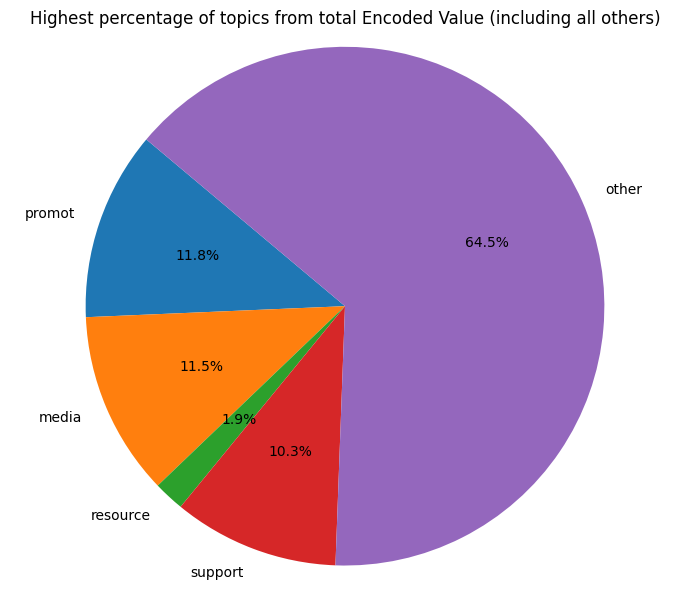

In [7]:

# Sum of the total Encoded Value to calculate percentages
total_sum = mapping_Option['Encoded Value'].sum()

# List of topics of interest
topics = ['promot'  , 'media' , 'resource'    , 'support'  ]

total_sum = mapping_Option['Encoded Value'].sum()
results = {}

# Calculate percentage for each subject
for topic in topics:
    topic_df = mapping_Option[mapping_Option['Unique Value'].astype(str).str.lower().str.contains(topic)]
    topic_sum = topic_df['Encoded Value'].sum()
    percentage = (topic_sum / total_sum) * 100 if total_sum != 0 else 0
    results[topic] = percentage

# Calculate the percentage of other items
sum_known_percentages = sum(results.values())
results['other'] = 100 - sum_known_percentages

# Draw a chart
labels = list(results.keys())
sizes = list(results.values())
#colors = ['#ff9999','#66b3ff','#99ff99', '#dddddd']

plt.figure(figsize=(7, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)#, colors=colors)
plt.title("Highest percentage of topics from total Encoded Value (including all others)")
plt.axis('equal')
plt.tight_layout() 

plt.savefig('../results/Footballers/topic_bar_chart.png', dpi=200)
plt.show()


## Step 2: Calculate the Pearson correlation coefficient

In [8]:
# Calculate Pearson correlation coefficient
pearson_corr = df[['Main_Topic', 'Sub_Topic', 'Option']].corr(method='pearson')
print("Pearson Correlation Matrix:")
print(pearson_corr)

Pearson Correlation Matrix:
            Main_Topic  Sub_Topic    Option
Main_Topic    1.000000   0.357885  0.221568
Sub_Topic     0.357885   1.000000  0.063341
Option        0.221568   0.063341  1.000000


## Step 3: Chi-square test for categorical data

In [9]:
# Create a compromise table
contingency_table = pd.crosstab(df['Main_Topic'], df['Option'])

# Perform the Chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Show results
print(f"Chi-Square Value: {chi2}")
print(f"P-Value: {p_value}")

Chi-Square Value: 5084.976532081294
P-Value: 0.0


## Step 4: Interpretation of Results
- P-Value < 0.05 ===> There is a significant relationship

In [10]:
def encoded_data(importance_df, mapping_option_df):
    """
    Process to create a dataFrame from two dataframe 

    Parameters:
        importance_df   as input 
        mapping_option_df     as input
        result_df    as output

    output:
          A dataframe Includes columns:   Importance و name.
    """


    # Create a dictionary from the mapping-option.xlsx file
    mapping_dict = dict(zip(mapping_option_df["Encoded Value"], mapping_option_df["Unique Value"]))
    print(mapping_dict)

    # Convert Feature column values
    def process_feature(feature):
        try:
            # Attempt to convert to integer
            return int(feature)
        except ValueError:
            # If it cannot be converted to a number, return the original value
            return feature

    # Apply transformation to Feature column
    importance_df["Feature"] = importance_df["Feature"].apply(process_feature)

    # Apply transformation to Feature column
    def map_feature(feature):
        return mapping_dict.get(feature, feature)

    # Create a new column name
    importance_df["name"] = importance_df["Feature"].apply(map_feature)

    # Select final columns
    result_df = importance_df[["Importance", "name"]]

    return result_df

## Step 5: Choose the right machine learning models

For multi-class classification data (Main_Topic and Sub_Topic), the following models can be used:

 - Logistic Regression 

 - Decision Trees and Random Forest 

 - Support Vector Machine (SVM) 

 - Naive Bayes 

In [11]:

def train_and_evaluate_models(dataframe , mapping_df):
    """
        The created function now processes the input data and evaluates it using four machine learning models
        (Naive Bayes, Logistic Regression, Random Forest, SVM)
        and selects the best model based on accuracy.


        Parameters:
            dataframe   as input dataframe
            mapping_df     as target column
            result    as   Best model
        output:
          print Best Model
    """
    
    X = dataframe['Questions'] + ' ' + dataframe['Option'].astype('str')
    y = dataframe['Main_Topic'].astype('str')

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    vectorizer = CountVectorizer()
    X_vectorized = vectorizer.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_encoded, test_size=0.25, random_state=0)

    models = {
        'Naive Bayes': MultinomialNB(),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(),
        'Support Vector Machine': SVC()
    }

    results = {}

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results[model_name] = accuracy

        print(f"{model_name} Accuracy: {accuracy}")
        print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
        # Using class names in the Confusion Matrix diagram
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(7, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels= mapping_df['Unique Value'],
                    yticklabels= mapping_df['Unique Value'])
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f"Confusion Matrix - {model_name}")
        plt.show()

    best_model = max(results, key=results.get)
    print(f"Best Model: {best_model} with accuracy {results[best_model]}")
    

        
    # Convert dictionary to list for drawing
    models = list(results.keys())
    scores = list(results.values())

    # Draw a bar chart
    plt.figure(figsize=(8, 5))
    bars = plt.bar(models, scores, color=['#66b3ff', '#99ff99', '#ffcc99', '#ff9999'])
    
    # Add percentage to the top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2%}', ha='center', fontsize=10)
    
    # Graphic settings
    plt.ylim(0, 1.1)
    plt.ylabel('Accuracy')
    plt.title('Comparison of the accuracy of different models')
    plt.xticks(rotation=15)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('../results/Footballers/Comparison_accuracy.png', dpi=200)
    plt.show()
    
    return results

Naive Bayes Accuracy: 0.7444717444717445
              precision    recall  f1-score   support

           0       0.38      1.00      0.55        28
           1       0.23      1.00      0.37         5
           2       0.89      0.71      0.79        72
           3       0.62      0.87      0.72        55
           4       0.97      0.69      0.81       247

    accuracy                           0.74       407
   macro avg       0.62      0.85      0.65       407
weighted avg       0.86      0.74      0.77       407



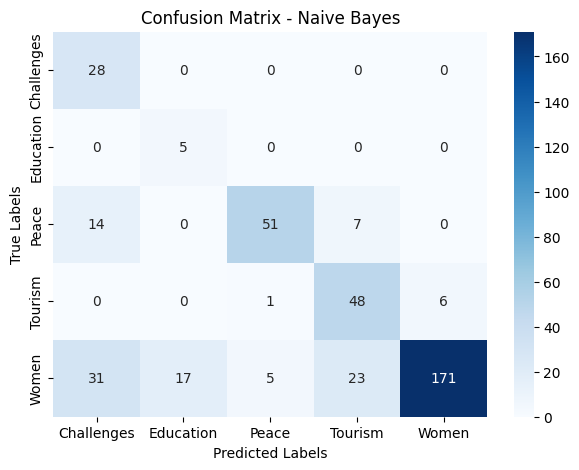

Logistic Regression Accuracy: 0.972972972972973
              precision    recall  f1-score   support

           0       1.00      0.68      0.81        28
           1       1.00      1.00      1.00         5
           2       0.97      1.00      0.99        72
           3       1.00      1.00      1.00        55
           4       0.96      0.99      0.98       247

    accuracy                           0.97       407
   macro avg       0.99      0.93      0.95       407
weighted avg       0.97      0.97      0.97       407



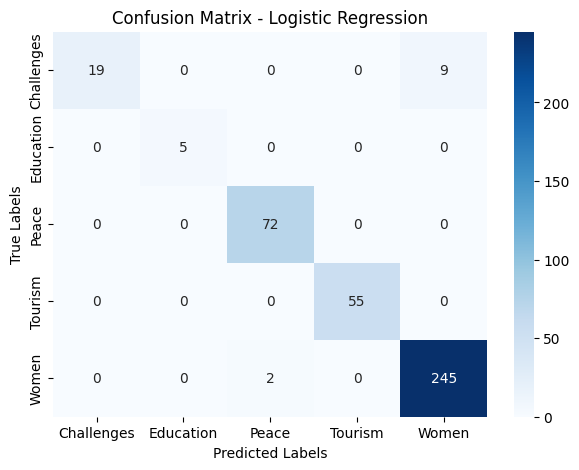

Random Forest Accuracy: 0.9901719901719902
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        28
           1       1.00      1.00      1.00         5
           2       0.99      1.00      0.99        72
           3       1.00      1.00      1.00        55
           4       1.00      0.98      0.99       247

    accuracy                           0.99       407
   macro avg       0.98      1.00      0.99       407
weighted avg       0.99      0.99      0.99       407



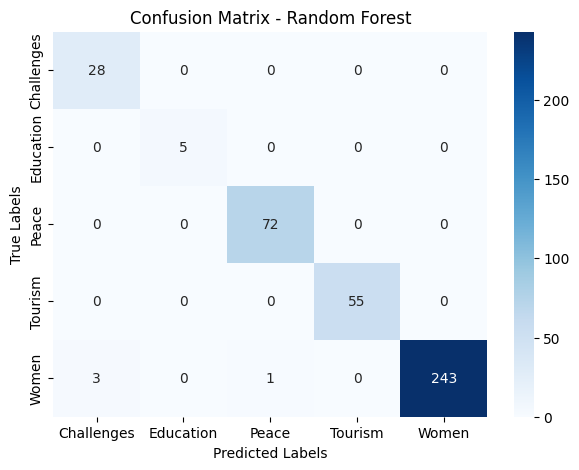

Support Vector Machine Accuracy: 0.9115479115479116
              precision    recall  f1-score   support

           0       1.00      0.68      0.81        28
           1       1.00      1.00      1.00         5
           2       0.81      0.92      0.86        72
           3       1.00      0.78      0.88        55
           4       0.92      0.96      0.94       247

    accuracy                           0.91       407
   macro avg       0.95      0.87      0.90       407
weighted avg       0.92      0.91      0.91       407



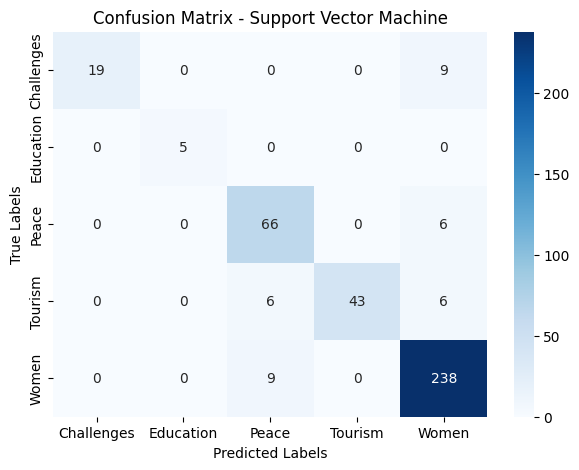

Best Model: Random Forest with accuracy 0.9901719901719902


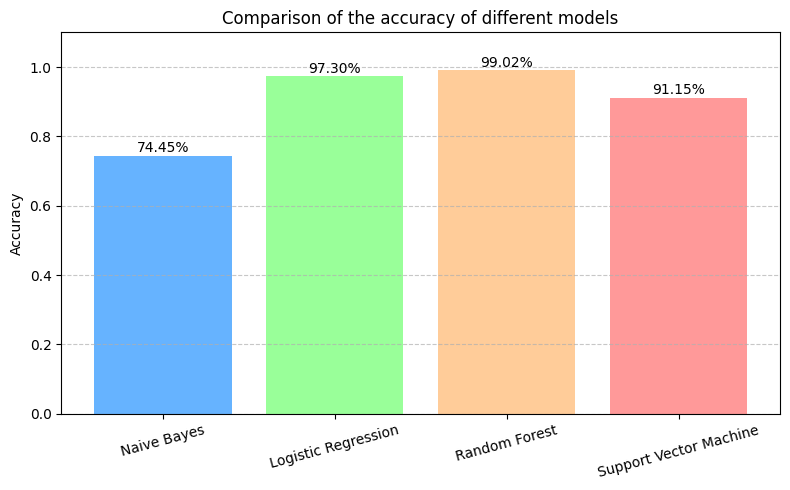

{'Naive Bayes': 0.7444717444717445,
 'Logistic Regression': 0.972972972972973,
 'Random Forest': 0.9901719901719902,
 'Support Vector Machine': 0.9115479115479116}

In [12]:
train_and_evaluate_models(df, mapping_Main_Topic)

In [13]:
def train_and_evaluate_models_with_animation(dataframe, mapping_df, epochs=20):
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    import seaborn as sns
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.linear_model import SGDClassifier
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import LabelEncoder
    import pandas as pd
    import numpy as np

    # آماده‌سازی داده‌ها
    X = dataframe['Questions'] + ' ' + dataframe['Option'].astype(str)
    y = dataframe['Main_Topic'].astype(str)

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    vectorizer = CountVectorizer()
    X_vectorized = vectorizer.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_vectorized, y_encoded, test_size=0.25, random_state=0
    )

    # مدل با warm_start برای یادگیری مرحله‌ای
    model = SGDClassifier(loss='log_loss', max_iter=1, warm_start=True, random_state=0)

    # لیست برای نگهداری دقت‌ها
    accuracies = []

    # پلات اولیه
    fig, ax = plt.subplots(figsize=(7, 5))
    line, = ax.plot([], [], 'b-', lw=2)
    ax.set_xlim(0, epochs)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Learning Progress - Accuracy over Epochs')

    def init():
        line.set_data([], [])
        return line,

    def update(epoch):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)

        xdata = np.arange(1, len(accuracies) + 1)
        ydata = np.array(accuracies)
        line.set_data(xdata, ydata)

        print(f"Epoch {epoch+1}/{epochs} - Accuracy: {acc:.2%}")
        return line,

    ani = animation.FuncAnimation(
        fig, update, frames=epochs, init_func=init, blit=True, repeat=False
    )

    # ذخیره انیمیشن به صورت gif
    ani.save('../results/Footballers/learning_progress.gif', writer='pillow', fps=2)
    plt.show()

    # گزارش نهایی پس از آخرین epoch
    final_pred = model.predict(X_test)
    final_acc = accuracy_score(y_test, final_pred)
    print(f"\nFinal Accuracy after {epochs} epochs: {final_acc:.2%}")
    print(classification_report(y_test, final_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, final_pred)
    labels = mapping_df['Unique Value'].tolist() if 'Unique Value' in mapping_df.columns else label_encoder.classes_

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix - Final Epoch')
    plt.tight_layout()
    plt.show()

    return final_acc, model


C:\Users\nouri\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\nouri\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\nouri\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\nouri\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consid

Epoch 1/20 - Accuracy: 83.29%
Epoch 2/20 - Accuracy: 86.73%
Epoch 3/20 - Accuracy: 80.10%
Epoch 4/20 - Accuracy: 87.22%


C:\Users\nouri\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\nouri\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\nouri\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\nouri\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consid

Epoch 5/20 - Accuracy: 76.66%
Epoch 6/20 - Accuracy: 85.50%
Epoch 7/20 - Accuracy: 84.52%
Epoch 8/20 - Accuracy: 78.38%


C:\Users\nouri\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\nouri\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\nouri\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\nouri\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consid

Epoch 9/20 - Accuracy: 72.24%
Epoch 10/20 - Accuracy: 86.49%
Epoch 11/20 - Accuracy: 76.66%
Epoch 12/20 - Accuracy: 84.52%
Epoch 13/20 - Accuracy: 77.89%


C:\Users\nouri\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\nouri\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\nouri\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\nouri\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consid

Epoch 14/20 - Accuracy: 75.18%
Epoch 15/20 - Accuracy: 82.06%
Epoch 16/20 - Accuracy: 81.57%
Epoch 17/20 - Accuracy: 73.46%


C:\Users\nouri\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\nouri\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\nouri\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Epoch 18/20 - Accuracy: 76.66%
Epoch 19/20 - Accuracy: 80.59%
Epoch 20/20 - Accuracy: 82.31%


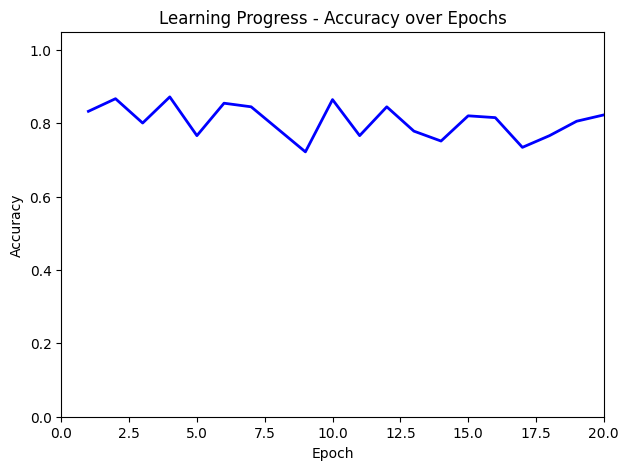


Final Accuracy after 20 epochs: 82.31%
              precision    recall  f1-score   support

           0       1.00      0.25      0.40        28
           1       0.11      1.00      0.19         5
           2       0.98      0.78      0.87        72
           3       1.00      0.53      0.69        55
           4       0.89      0.96      0.93       247

    accuracy                           0.82       407
   macro avg       0.80      0.70      0.62       407
weighted avg       0.92      0.82      0.84       407



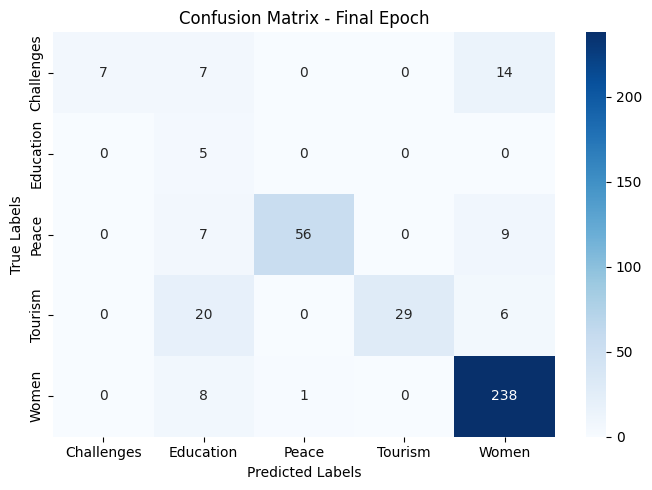

(0.8230958230958231,
 SGDClassifier(loss='log_loss', max_iter=1, random_state=0, warm_start=True))

In [15]:
train_and_evaluate_models_with_animation(df, mapping_Main_Topic)

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def prepare_data_for_modeling(dataframe, question_col='Questions', option_col='Option', target_col='Main_Topic'):
    """
    آماده‌سازی داده برای مدل‌های یادگیری ماشین:
    - ترکیب سوال و گزینه
    - بردارسازی متن با CountVectorizer
    - رمزگذاری برچسب هدف با LabelEncoder
    - ساخت جدول نگاشت برچسب‌ها
    
    پارامترها:
        dataframe      : دیتافریم اصلی
        question_col   : نام ستون سوالات
        option_col     : نام ستون گزینه‌ها
        target_col     : نام ستون متغیر هدف
    
    خروجی:
        X_vectorized   : بردارهای ویژگی متنی
        y_encoded      : برچسب‌های عددی
        label_encoder  : شی LabelEncoder آموزش‌دیده
        mapping_df     : نگاشت برچسب‌ها
    """
    
    # ترکیب سوال و گزینه برای بردارسازی
    X = dataframe[question_col] + ' ' + dataframe[option_col].astype(str)
    y = dataframe[target_col].astype(str)

    # بردارسازی با CountVectorizer
    vectorizer = CountVectorizer()
    X_vectorized = vectorizer.fit_transform(X)

    # رمزگذاری برچسب‌ها
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # ساخت نگاشت برچسب‌ها
    mapping_df = pd.DataFrame({
        'Original Value': label_encoder.classes_,
        'Unique Value': label_encoder.classes_  # می‌تونی به فارسی هم ترجمه کنی یا کد بدی
    })

    return X_vectorized, y_encoded, label_encoder, mapping_df

In [23]:
X_vectorized, y_encoded, label_encoder, mapping_df = prepare_data_for_modeling(df)


In [24]:
def animate_learning_curve_static_models(X_vectorized, y_encoded, model, model_name, label_encoder, mapping_df, steps=10):
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.animation as animation
    from sklearn.metrics import accuracy_score

    from sklearn.model_selection import train_test_split

    # تقسیم داده‌ها (هر بار فقط آموزش را از نو انجام می‌دهیم)
    X_train_full, X_test, y_train_full, y_test = train_test_split(X_vectorized, y_encoded, test_size=0.25, random_state=0)

    data_size = X_train_full.shape[0]
    step_size = data_size // steps

    accuracies = []

    fig, ax = plt.subplots(figsize=(7, 5))
    line, = ax.plot([], [], 'r-', lw=2)
    ax.set_xlim(0, steps)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel('Training Data Size Step')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Learning Progress - {model_name}')

    def init():
        line.set_data([], [])
        return line,

    def update(step):
        current_size = (step + 1) * step_size
        X_train = X_train_full[:current_size]
        y_train = y_train_full[:current_size]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)

        xdata = np.arange(1, len(accuracies) + 1)
        ydata = np.array(accuracies)
        line.set_data(xdata, ydata)

        print(f"{model_name} - Step {step + 1}/{steps} - Training size: {current_size}, Accuracy: {acc:.2%}")
        return line,

    ani = animation.FuncAnimation(
        fig, update, frames=steps, init_func=init, blit=True, repeat=False
    )

    ani.save(f'../results/Footballers/{model_name.replace(" ", "_")}_learning_progress.gif', writer='pillow', fps=2)
    plt.show()

    return accuracies


Naive Bayes - Step 1/10 - Training size: 122, Accuracy: 76.17%
Naive Bayes - Step 2/10 - Training size: 244, Accuracy: 69.78%
Naive Bayes - Step 3/10 - Training size: 366, Accuracy: 72.97%
Naive Bayes - Step 4/10 - Training size: 488, Accuracy: 72.24%
Naive Bayes - Step 5/10 - Training size: 610, Accuracy: 73.96%
Naive Bayes - Step 6/10 - Training size: 732, Accuracy: 76.66%
Naive Bayes - Step 7/10 - Training size: 854, Accuracy: 76.66%
Naive Bayes - Step 8/10 - Training size: 976, Accuracy: 77.89%
Naive Bayes - Step 9/10 - Training size: 1098, Accuracy: 73.96%
Naive Bayes - Step 10/10 - Training size: 1220, Accuracy: 74.45%


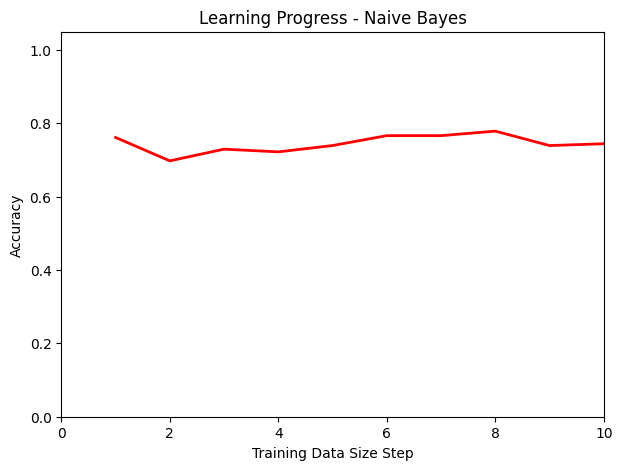

Random Forest - Step 1/10 - Training size: 122, Accuracy: 89.43%
Random Forest - Step 2/10 - Training size: 244, Accuracy: 96.81%
Random Forest - Step 3/10 - Training size: 366, Accuracy: 97.54%
Random Forest - Step 4/10 - Training size: 488, Accuracy: 97.54%
Random Forest - Step 5/10 - Training size: 610, Accuracy: 98.77%
Random Forest - Step 6/10 - Training size: 732, Accuracy: 99.02%
Random Forest - Step 7/10 - Training size: 854, Accuracy: 99.02%
Random Forest - Step 8/10 - Training size: 976, Accuracy: 99.02%
Random Forest - Step 9/10 - Training size: 1098, Accuracy: 99.02%
Random Forest - Step 10/10 - Training size: 1220, Accuracy: 99.02%


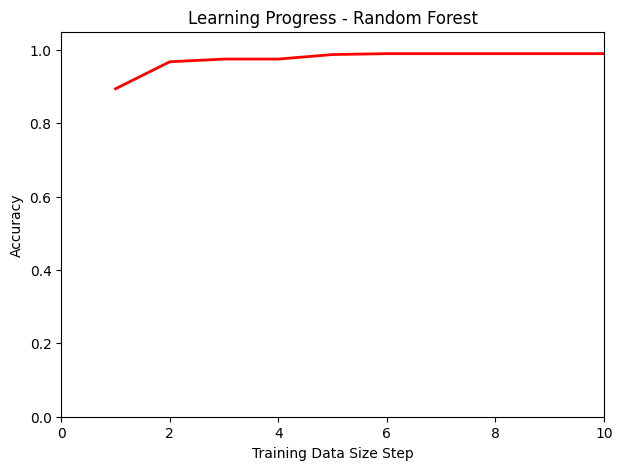

Support Vector Machine - Step 1/10 - Training size: 122, Accuracy: 74.20%
Support Vector Machine - Step 2/10 - Training size: 244, Accuracy: 78.38%
Support Vector Machine - Step 3/10 - Training size: 366, Accuracy: 78.38%
Support Vector Machine - Step 4/10 - Training size: 488, Accuracy: 78.38%
Support Vector Machine - Step 5/10 - Training size: 610, Accuracy: 80.34%
Support Vector Machine - Step 6/10 - Training size: 732, Accuracy: 84.28%
Support Vector Machine - Step 7/10 - Training size: 854, Accuracy: 85.26%
Support Vector Machine - Step 8/10 - Training size: 976, Accuracy: 87.71%
Support Vector Machine - Step 9/10 - Training size: 1098, Accuracy: 88.45%
Support Vector Machine - Step 10/10 - Training size: 1220, Accuracy: 91.15%


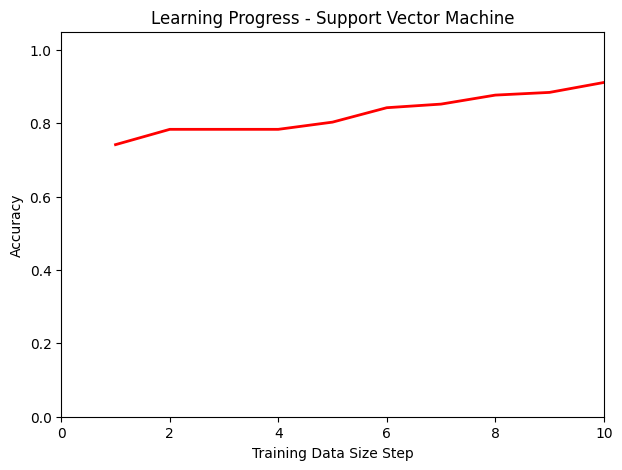

[0.742014742014742,
 0.7837837837837838,
 0.7837837837837838,
 0.7837837837837838,
 0.8034398034398035,
 0.8427518427518428,
 0.8525798525798526,
 0.8771498771498771,
 0.8845208845208845,
 0.9115479115479116]

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# فرض: label_encoder, mapping_df, X_vectorized, y_encoded آماده هستند

animate_learning_curve_static_models(X_vectorized, y_encoded, MultinomialNB(), "Naive Bayes", label_encoder, mapping_df)
animate_learning_curve_static_models(X_vectorized, y_encoded, RandomForestClassifier(), "Random Forest", label_encoder, mapping_df)
animate_learning_curve_static_models(X_vectorized, y_encoded, SVC(), "Support Vector Machine", label_encoder, mapping_df)


## Step 6 :Calculate important features

In [42]:
def calculate_feature_importance(dataframe , mapping_option):
    # Convert columns to strings to avoid errors
    dataframe['Option'] = dataframe['Option']

    # Combining questions and options
    X = dataframe['Questions'].astype('str') + ' ' + dataframe['Option'].astype('str')
    y = dataframe['Main_Topic'].astype('str')

    # Convert labels to numbers
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Convert text to numeric data
    vectorizer = CountVectorizer()
    X_vectorized = vectorizer.fit_transform(X)

    # Splitting the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_encoded, test_size=0.2, random_state=42)

    # Create a Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Calculating the importance of features
    feature_importances = rf_model.feature_importances_
    feature_names = vectorizer.get_feature_names_out()

       

    # Display high-importance features
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

    result_df = encoded_data(importance_df, mapping_option)
    
     

    
    # Draw a graph of the importance of features
    plt.figure(figsize=(14, 8))
    plt.barh(result_df['name'], result_df['Importance'], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.title('Top 20 Feature Importances (Random Forest)')
    plt.gca().invert_yaxis()
    plt.savefig('../results/Footballers/feature_importance.jpg' , bbox_inches='tight')
    plt.show()
    
    result_df = pd.DataFrame(result_df)
    result_df.to_excel('../results/Footballers/feature_importance.xlsx')
    

    return importance_df

{0: '0', 1: '4', 2: 'Addressing cultural and social barriers', 3: 'Addressing political and legal restrictions', 4: 'As a platform to bring people together, break barriers, and promote cross-cultural understanding', 5: 'As role models and ambassadors of peace', 6: 'Assistant to the head ', 7: 'Bachelor', 8: 'Combating discrimination and bias', 9: 'Creating a safe and inclusive environment for women to play football', 10: 'Creating opportunities and challenges for destination management', 11: 'Creating opportunities for women to play football', 12: 'Economic benefits', 13: 'Empowering women to be leaders in sports', 14: 'Encouraging sports diplomacy', 15: 'Encouraging them to participate in peace initiatives', 16: 'Encouraging tourism', 17: 'Encouraging women to participate in major sporting events', 18: 'Ensuring security', 19: 'Female', 20: 'Fostering an inclusive culture', 21: 'Gender discrimination', 22: 'Governmental', 23: 'Helping to challenge gender stereotypes and promote gender

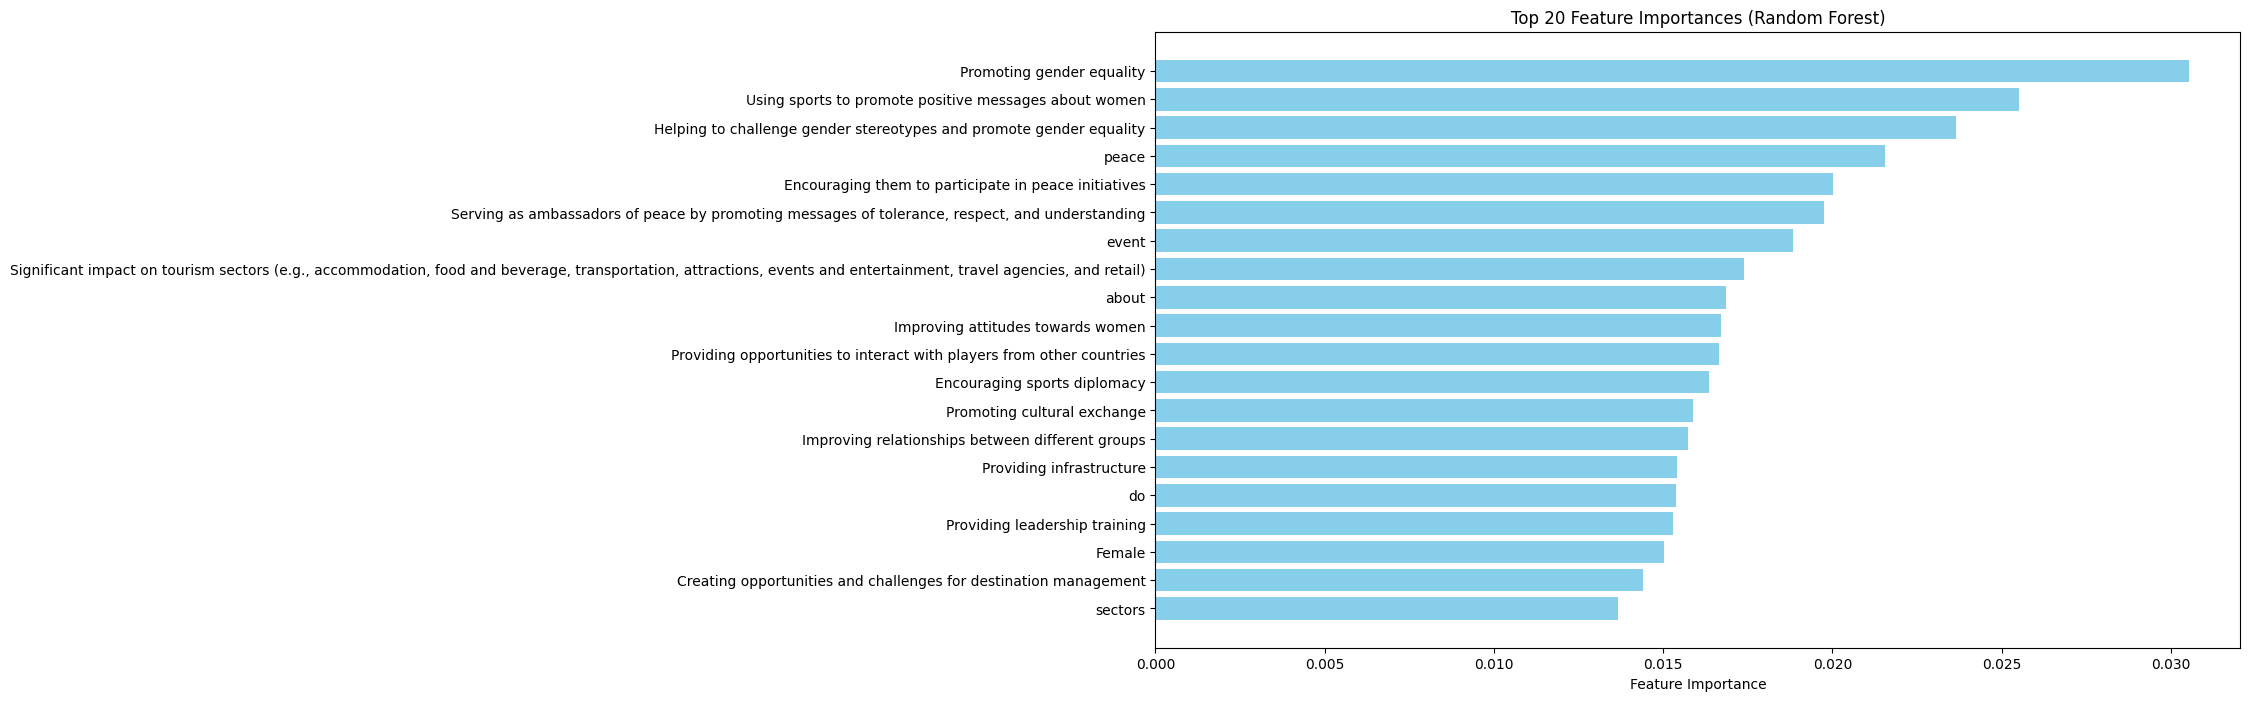

,Feature,Importance,name
45,55,0.030525,Promoting gender equality
64,74,0.025514,Using sports to promote positive messages abou...
13,23,0.023663,Helping to challenge gender stereotypes and pr...
208,peace,0.021558,peace
5,15,0.020016,Encouraging them to participate in peace initi...
58,68,0.019750,Serving as ambassadors of peace by promoting m...
134,event,0.018839,event
59,69,0.017399,"Significant impact on tourism sectors (e.g., a..."
77,about,0.016870,about
17,27,0.016695,Improving attitudes towards women


In [43]:
calculate_feature_importance(df , mapping_Option)